## Projektaufgaben
1. Es kommt häufiger vor, dass man mehrdimensionale Daten "flachmachen", also in einen eindimensionalen Tensor umwandeln muss. Können Sie das als Pytorch-Modul lösen, sodass Sie es später wiederverwenden können? Vergessen Sie nicht, dass bei zweidimensionalen Bilddaten der Input-Tensor vierdimensional sein kann, da die erste Dimension eventuell der Batch-Index und die zweite der Farbkanal ist. In diesem Fall dürfen nur die letzten drei Dimensionen zusammengefasst werden. Eventuell finden Sie ein hilfreiches Modul in der [PyTorch Dokumentation](https://pytorch.org/docs/stable/nn.html)...
2. MNIST ist ein Klassifizierungsproblem. Es bietet sich also an, eine *Accuracy*-Metrik zu implementieren: Schreiben Sie eine Funktion, die als Input eine Batch an Labels und eine Batch an Predictions erhält und darauf den Anteil an korrekt klassifizierten Beispielen berechnet. Integrieren Sie die Funktion in den Trainingsloop, sodass Ihnen nicht nur der Trainings- und Validation-Loss sondern auch die Trainings- und Validation-Accuracy angezeigt wird. Ihre Implementierung sollte keine Schleifen enthalten, sondern auf Tensoroperationen basieren. Tipp: Eine Übersicht aller Tensoroperationen finden Sie [hier](https://pytorch.org/docs/stable/tensors.html#tensor-class-reference).
3. Bauen Sie ein MLP für MNIST als PyTorch-Modul. Nutzen Sie dabei Ihr Modul aus Aufgabe 1. und die typischen Bausteine aus `torch.nn`.
4. Trainieren Sie das MLP aus 3. auf MNIST und experimentieren Sie mit verschiedenen Hyperparametern und Netzwerkstrukturen. Beispielsweise:
    - Anzahl der Hidden Layer
    - Anzahl der Hidden Neurons
    - Aktivierungsfunktion
    - Last-Layer-Aktivierungsfunktion
    - Loss-Funktion
    - Optimierungsmethode
    - Learning Rate
5. Finden Sie einen eigenen Datensatz Ihrer Wahl ([Kaggle](https://www.kaggle.com/datasets) o.Ä. ist als Quelle in Ordnung), implementieren Sie gegebenenfalls ein eigenes `Dataset` und versuchen Sie mithilfe des Gelernten aus den vorherigen Aufgaben ein möglichst gutes MLP zu trainieren.

Bitte fassen Sie Ihre Lösungen in einem eigenen Jupyter-Notebook zusammen!

# Preparation

In [39]:
import IPython
import matplotlib
import matplotlib.pyplot as plt
import seaborn

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import multiprocessing
import psutil


rand_seed = 42
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

In [40]:
# Wer eine Nvidia GPU zur Verfügung hat kann auch CUDA nutzen:
force_use_cpu = False
if torch.cuda.is_available() and not force_use_cpu:    
    print(f"CUDA device available: {torch.cuda.get_device_name()}")
    use_cuda = True
else:
    print(f"CUDA not available or disabled, using CPU.")
    use_cuda = False
    
#cpu_cores = multiprocessing.cpu_count() # logische CPUs
cpu_cores = psutil.cpu_count(logical=False)
print(f"Available CPU cores: {cpu_cores}")

CUDA not available or disabled, using CPU.
Available CPU cores: 1


In [41]:
 def inference(model, data):
    with torch.no_grad():
        model.eval()
        if use_cuda:
            prediction = model.forward(data.cuda())
        else:
            prediction = model.forward(data)
        return prediction
        
        
def show_multiple_predictions(model, test_dataset, x_samples=3, y_samples=3):
    num_samples = x_samples*y_samples

    random_indices = (np.random.random_sample(num_samples) * len(test_dataset)).astype(int)

    fig, axes = plt.subplots(x_samples, y_samples, figsize=(15,15))
    flat_axes = np.ravel(axes)


    with torch.no_grad():
        for i, index in enumerate(random_indices):
            prediction = inference(model, test_dataset[index][0])
            flat_axes[i].imshow(test_dataset.data[index])
            flat_axes[i].set_title(f"{prediction.argmax()}")
            flat_axes[i].set_xticks([])
            flat_axes[i].set_yticks([])

In [42]:
def train_and_validate(model, tl, vl, epochs, optim, loss_func, verbose=False, log_interval=1):
    val_loss_final = []
    train_loss_final = []
    train_acc_final = []
    val_acc_final = []
    for epoch in range(1, epochs+1):
        epoch_correct = 0
        train_epoch_losses = []
        val_epoch_losses = []
        train_epoch_acc = []
        val_epoch_acc = []
        model.train() # Model in den Trainings-Modus setzen.
                      # Es gibt bestimmte Module, die sich je nachdem, ob man trainiert oder Inferenz betreibt, 
                      # anders verhalten. Mehr dazu später.
        for inputs, labels in tl:
            optim.zero_grad()
            pred = model.forward(inputs)

            train_acc =  accuracy(pred.argmax(dim=1), labels)
            train_epoch_acc.append(train_acc)

            loss = loss_func(pred, labels)
            train_epoch_losses.append(loss.item())

            loss.backward()
            optim.step()

        if epoch % log_interval == 0:
            with torch.no_grad():
                model.eval() # Model in den Evaluations-/Inferenz-Modus setzen.

                for inputs, labels in vl:
                    pred = model.forward(inputs)
                    val_acc =  accuracy(pred.argmax(dim=1), labels)
                    val_epoch_acc.append(val_acc)
                    loss = loss_func(pred, labels)
                    val_epoch_losses.append(loss.item())

            val_loss_final.append(np.mean(val_epoch_losses))
            train_loss_final.append(np.mean(train_epoch_losses))
            train_acc_final.append(np.mean(train_epoch_acc))
            val_acc_final.append(np.mean(val_epoch_acc))
            if verbose: 
              print(f"Epoch {epoch}")
              print(f"Average training loss: {np.mean(train_epoch_losses)}")
              print(f"Average validation loss: {np.mean(val_epoch_losses)}")
              print(f"Average training acc: {np.mean(train_epoch_acc)}")
              print(f"Average validation acc: {np.mean(val_epoch_acc)}")
              print("----------------------------\n")

    return train_loss_final, val_loss_final, train_acc_final, val_acc_final

In [43]:
dataset_folder = "mnist_dataset"

mnist = torchvision.datasets.MNIST(dataset_folder, download=True)

In [44]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
])

train_dataset = torchvision.datasets.MNIST(dataset_folder, train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.MNIST(dataset_folder, train=False, download=True, transform=transforms)

In [45]:
batch_size = 4096

num_workers = cpu_cores
persistent_workers = True
#num_workers = 0 # No multi-processing
#persistent_workers = False
# Achtung, eventuell _muss_ num_workers auf 0 gesetzt werden (vor allem unter Windows).
# Siehe auch: https://github.com/pytorch/pytorch/issues/15849
# Unabhängig davon ist es auch manchmal schneller, wenn alles in einem Thread läuft,
# weil das Laden der Daten nicht CPU-limitiert ist.

pin_memory = use_cuda
# Bezüglich des pin_memory Parameters siehe: https://pytorch.org/docs/stable/data.html#memory-pinning

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           pin_memory=pin_memory, 
                                           num_workers=num_workers,
                                           persistent_workers=persistent_workers)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          pin_memory=pin_memory, 
                                          num_workers=num_workers,
                                          persistent_workers=persistent_workers)

In [46]:
example_batch = iter(train_loader).next()

In [47]:
example_batch[1].shape


torch.Size([4096])

# Exercise 1

In [48]:
class MyFlatten(torch.nn.Module):
    def __init__(self, keep_first = False):
        super().__init__()
        self.keep_first = keep_first
    
    def forward(self, x):
        if self.keep_first:
            return torch.reshape(x, (x.size()[0], -1))
        else:
            return torch.reshape(x, (-1, ))

In [49]:
flatten = MyFlatten(True)
print(example_batch[0].shape)
batch_flattened = flatten.forward(example_batch[0])
batch_flattened.shape



torch.Size([4096, 1, 28, 28])


torch.Size([4096, 784])

# Exercise 2

In [50]:
a = torch.Tensor([[1,2,3,4,5,6,7],[6,7,8,9,10,11,0],[6,7,8,9,10,11,0]])
b = torch.Tensor([[1,1,3,1,5,6,1],[6,1,1,9,10,1,0],[6,1,1,9,10,1,1]])
print(a[a==b])

tensor([ 1.,  3.,  5.,  6.,  6.,  9., 10.,  0.,  6.,  9., 10.])


In [51]:
def accuracy(batch_pred, batch_true):
  # ALTERNATIVE WAY
  # t = torch.eq(batch_pred,batch_true)
  # return len(t[t==True])/torch.numel(batch_true)
  return len(batch_pred[batch_pred == batch_true])/torch.numel(batch_true)


In [52]:
print(accuracy(a,b))

0.5238095238095238


In [53]:
def calculate_accuracy(x, y):
    assert(x.size() == y.size())
    assert(x.nelement() == x.size(0))
    return sum(1 for x, y in zip(x, y) if x == y) / x.size(0)

# Exercise 3

In [54]:
class MLP(nn.Module):
    """Multi layer perceptron torch model."""
    def __init__(self, num_hidden_units=30, num_hidden_layers=1, act_fn=None):
        """Initialize model.

        Args:
            img_width (int): Width of images
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
            num_hidden_units (int, optional): Number of hidden units per layer. 
                Defaults to 30.
            num_hidden_layers (int, optional): Number of hidden layers. Total
                number of layers will be num_hidden_layers + 2. Defaults to 1.
            act_fn (nn activation function, optional): Activation function
                to use after the first and all the hidden layers. If None, use
                nn.ReLU(). Defaults to None.
        """
        super().__init__()
        if not act_fn:
          self.act_fn = nn.ReLU()

        #input layer
        self.layers = nn.ModuleList([nn.Linear(28*28, num_hidden_units)])

        #hidden layers
        for i in range(num_hidden_layers):
          self.layers.append(nn.Linear(num_hidden_units, num_hidden_units))

        #output layer
        self.output_layer = nn.Linear(num_hidden_units, 10)

    
    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        # x = torch.flatten(x, 1)
        flat = MyFlatten(True)
        x = flat.forward(x)
        for layer in self.layers:
          x = self.act_fn(layer(x))
        
        return self.output_layer(x)


In [55]:
mlpModel = MLP()
lr=0.01
epochs = 10
# loss_func = F.mse_loss # torch.nn.functional beinhaltet häufig benötigte Funktionen. So müssen wir für einfache
                       # Methoden nicht jedes mal ein eigenes Objekt erzeugen.
loss_func = nn.CrossEntropyLoss() ####### TODO Change loss function
optim = torch.optim.Adam(params=mlpModel.parameters(), lr=lr)
# losses, val_loss = train_and_validate(mlpModel, train_loader, test_loader, epochs, optim, loss_func, True)

# Exercise 4

## Changing number of hidden layers to [1, 3, 5, 7]

In [56]:
########################
## Hidden Layers = 1 ##
########################

mlpModel1 = MLP()
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=mlpModel1.parameters(), lr=lr)
losses_1_layers, val_loss_1_layers, acc_train_1_layers, acc_val_1_layers = train_and_validate(mlpModel1, train_loader, test_loader, epochs, optim, loss_func, True)

Epoch 1
Average training loss: 1.2411144018173217
Average validation loss: 0.5087961057821909
Average training acc: 0.5831852801832329
Average validation acc: 0.8535257075036874
----------------------------

Epoch 2
Average training loss: 0.4189165035883586
Average validation loss: 0.32384411493937176
Average training acc: 0.8759838180848393
Average validation acc: 0.9071732692662242
----------------------------

Epoch 3
Average training loss: 0.29845311840375266
Average validation loss: 0.25024854640165967
Average training acc: 0.911849938817771
Average validation acc: 0.9260405143805309
----------------------------

Epoch 4
Average training loss: 0.24245530863602957
Average validation loss: 0.21180502573649088
Average training acc: 0.928943312311747
Average validation acc: 0.9362713749078172
----------------------------

Epoch 5
Average training loss: 0.20642941296100617
Average validation loss: 0.1880150685707728
Average training acc: 0.9386795227786144
Average validation acc: 0.944

In [ ]:
########################
## Hidden Layers = 3 ##
########################

mlpModel3 = MLP(30, 3)
optim = torch.optim.Adam(params=mlpModel3.parameters(), lr=lr)
losses_3_layers, val_loss_3_layers, acc_train_3_layers, acc_val_3_layers = train_and_validate(mlpModel3, train_loader, test_loader, epochs, optim, loss_func, True)

In [ ]:
########################
## Hidden Layers = 5 ##
########################

mlpModel5 = MLP(30, 5)
optim = torch.optim.Adam(params=mlpModel5.parameters(), lr=lr)
losses_5_layers, val_loss_5_layers, acc_train_5_layers, acc_val_5_layers = train_and_validate(mlpModel5, train_loader, test_loader, epochs, optim, loss_func, True)

In [22]:
########################
## Hidden Layers = 7 ##
########################

mlpModel7 = MLP(30, 7)
optim = torch.optim.Adam(params=mlpModel7.parameters(), lr=lr)
losses_7_layers, val_loss_7_layers, acc_train_7_layers, acc_val_7_layers = train_and_validate(mlpModel7, train_loader, test_loader, epochs, optim, loss_func, True)

Epoch 9
Average training loss: 0.33067806363105773
Average validation loss: 0.3076433142026265
Average training acc: 0.9049577215110441
Average validation acc: 0.9129829519266224
----------------------------

Epoch 10
Average training loss: 0.28682649731636045
Average validation loss: 0.2767401585976283
Average training acc: 0.9172116199171687
Average validation acc: 0.9213701546367994
----------------------------



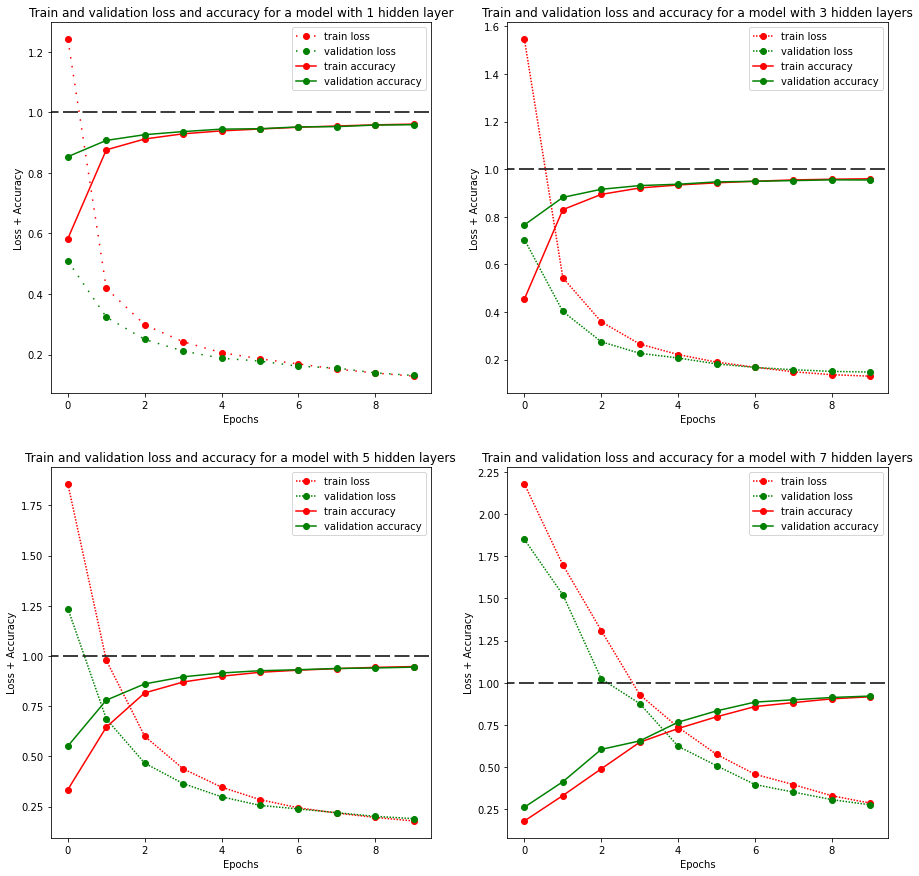

In [32]:
fig, axs = plt.subplots(2,2, figsize=(15,15)) 
axs[0,0].plot(losses_1_layers, linestyle = (0, (1, 5)), marker = 'o', label = 'train loss', c = 'r')
axs[0,0].plot(val_loss_1_layers, linestyle = (0, (1, 5)), marker = 'o', label = 'validation loss', c = 'g')
axs[0,0].plot(acc_train_1_layers, linestyle = '-', marker = 'o', label = 'train accuracy', c = 'r')
axs[0,0].plot(acc_val_1_layers, linestyle = '-', marker = 'o', label = 'validation accuracy', c = 'g')
axs[0,0].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss + Accuracy")
axs[0,0].set_title("Train and validation loss and accuracy for a model with 1 hidden layer")
axs[0,0].legend()

axs[0,1].plot(losses_3_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[0,1].plot(val_loss_3_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[0,1].plot(acc_train_3_layers, linestyle = '-', marker = 'o', label = 'train accuracy', c = 'r')
axs[0,1].plot(acc_val_3_layers, linestyle = '-', marker = 'o', label = 'validation accuracy', c = 'g')
axs[0,1].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Loss + Accuracy")
axs[0,1].set_title("Train and validation loss and accuracy for a model with 3 hidden layers")
axs[0,1].legend()

axs[1,0].plot(losses_5_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[1,0].plot(val_loss_5_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[1,0].plot(acc_train_5_layers, linestyle = '-', marker = 'o', label = 'train accuracy', c = 'r')
axs[1,0].plot(acc_val_5_layers, linestyle = '-', marker = 'o', label = 'validation accuracy', c = 'g')
axs[1,0].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss + Accuracy")
axs[1,0].set_title("Train and validation loss and accuracy for a model with 5 hidden layers")
axs[1,0].legend()

axs[1,1].plot(losses_7_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[1,1].plot(val_loss_7_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[1,1].plot(acc_train_7_layers, linestyle = '-', marker = 'o', label = 'train accuracy', c = 'r')
axs[1,1].plot(acc_val_7_layers, linestyle = '-', marker = 'o', label = 'validation accuracy', c = 'g')
axs[1,1].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Loss + Accuracy")
axs[1,1].set_title("Train and validation loss and accuracy for a model with 7 hidden layers")
axs[1,1].legend()


## Changing number of Hidden units per layer to [30, 60, 128, 256]

In [34]:
############################
## Number of Neurons = 30 ##
############################

mlpModel30 = MLP(30)
optim = torch.optim.Adam(params=mlpModel30.parameters(), lr=lr)
losses_30n, val_loss_30n, acc_30n, val_acc_30n = train_and_validate(mlpModel30, train_loader, test_loader, epochs, optim, loss_func, True)

Epoch 1
Average training loss: 1.068047034740448
Average validation loss: 0.43651772538820904
Average training acc: 0.6518911583835342
Average validation acc: 0.8768940703355458
----------------------------

Epoch 2
Average training loss: 0.37028915882110597
Average validation loss: 0.27989551921685535
Average training acc: 0.8920696457705823
Average validation acc: 0.9168841606747788
----------------------------

Epoch 3
Average training loss: 0.2664831876754761
Average validation loss: 0.22573339939117432
Average training acc: 0.9221730672690763
Average validation acc: 0.9337435471976402
----------------------------

Epoch 4
Average training loss: 0.21817195018132526
Average validation loss: 0.19454036156336466
Average training acc: 0.9358365101029116
Average validation acc: 0.9410015094948377
----------------------------

Epoch 5
Average training loss: 0.18487914005915324
Average validation loss: 0.17368306716283163
Average training acc: 0.9461021821661646
Average validation acc: 0.

In [35]:
############################
## Number of Neurons = 60 ##
############################

mlpModel60 = MLP(60)
optim = torch.optim.Adam(params=mlpModel60.parameters(), lr=lr)
losses_60n, val_loss_60n, acc_60n, val_acc_60n = train_and_validate(mlpModel60, train_loader, test_loader, epochs, optim, loss_func)

In [36]:
############################
## Number of Neurons = 128 ##
############################

mlpModel128 = MLP(128)
optim = torch.optim.Adam(params=mlpModel128.parameters(), lr=lr)
losses_128n, val_loss_128n, acc_128n, val_acc_128n = train_and_validate(mlpModel128, train_loader, test_loader, epochs, optim, loss_func)

In [37]:
############################
## Number of Neurons = 256 ##
############################

mlpModel256 = MLP(256)
optim = torch.optim.Adam(params=mlpModel256.parameters(), lr=lr)
losses_256n, val_loss_256n, acc_256n, val_acc_256n = train_and_validate(mlpModel256, train_loader, test_loader, epochs, optim, loss_func, True)

Epoch 1
Average training loss: 1.2248096704483031
Average validation loss: 0.3488737642765045
Average training acc: 0.6161736790913656
Average validation acc: 0.9004302348359144
----------------------------

Epoch 2
Average training loss: 0.27066048979759216
Average validation loss: 0.18119017283121744
Average training acc: 0.9189927679467871
Average validation acc: 0.9436820151179942
----------------------------

Epoch 3
Average training loss: 0.15825848678747814
Average validation loss: 0.13419024149576822
Average training acc: 0.9515291635291164
Average validation acc: 0.9582958840339234
----------------------------

Epoch 4
Average training loss: 0.11599824676911036
Average validation loss: 0.11161615202824275
Average training acc: 0.9643221322791165
Average validation acc: 0.9666283531526548
----------------------------

Epoch 5
Average training loss: 0.08913217733303706
Average validation loss: 0.10030069202184677
Average training acc: 0.9727384145958836
Average validation acc: 0

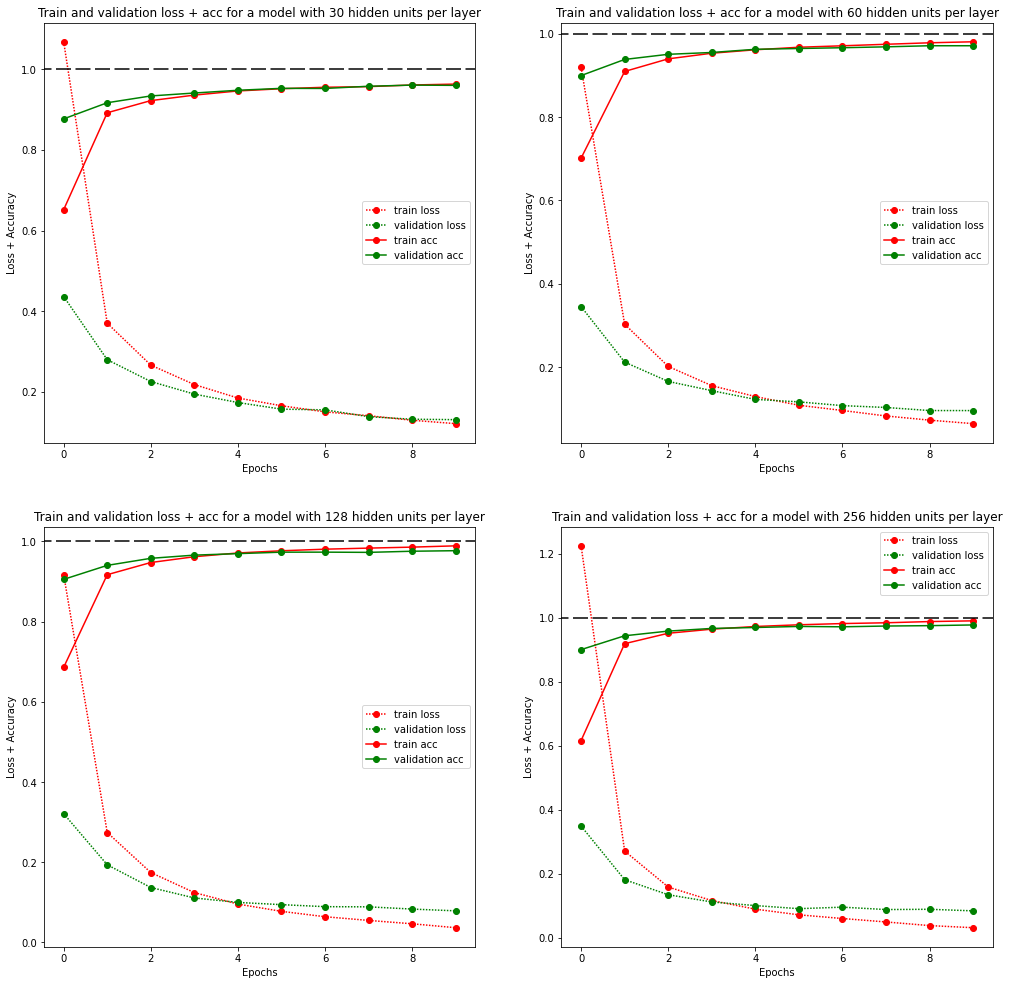

In [38]:
fig, axs = plt.subplots(2,2, figsize=(17,17))
axs[0,0].plot(losses_30n, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[0,0].plot(val_loss_30n, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[0,0].plot(acc_30n, linestyle = '-', marker = 'o', label = 'train acc', c = 'r')
axs[0,0].plot(val_acc_30n, linestyle = '-', marker = 'o', label = 'validation acc', c = 'g')
axs[0,0].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss + Accuracy")
axs[0,0].set_title("Train and validation loss + acc for a model with 30 hidden units per layer")
axs[0,0].legend()

axs[0,1].plot(losses_60n, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[0,1].plot(val_loss_60n, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[0,1].plot(acc_60n, linestyle = '-', marker = 'o', label = 'train acc', c = 'r')
axs[0,1].plot(val_acc_60n, linestyle = '-', marker = 'o', label = 'validation acc', c = 'g')
axs[0,1].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Loss + Accuracy")
axs[0,1].set_title("Train and validation loss + acc for a model with 60 hidden units per layer")
axs[0,1].legend()

axs[1,0].plot(losses_128n, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[1,0].plot(val_loss_128n, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[1,0].plot(acc_128n, linestyle = '-', marker = 'o', label = 'train acc', c = 'r')
axs[1,0].plot(val_acc_128n, linestyle = '-', marker = 'o', label = 'validation acc', c = 'g')
axs[1,0].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss + Accuracy")
axs[1,0].set_title("Train and validation loss + acc for a model with 128 hidden units per layer")
axs[1,0].legend()

axs[1,1].plot(losses_256n, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[1,1].plot(val_loss_256n, linestyle = (0, (1, 1)), marker = 'o', label = 'validation loss', c = 'g')
axs[1,1].plot(acc_256n, linestyle = '-', marker = 'o', label = 'train acc', c = 'r')
axs[1,1].plot(val_acc_256n, linestyle = '-', marker = 'o', label = 'validation acc', c = 'g')
axs[1,1].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Loss + Accuracy")
axs[1,1].set_title("Train and validation loss + acc for a model with 256 hidden units per layer")
axs[1,1].legend()


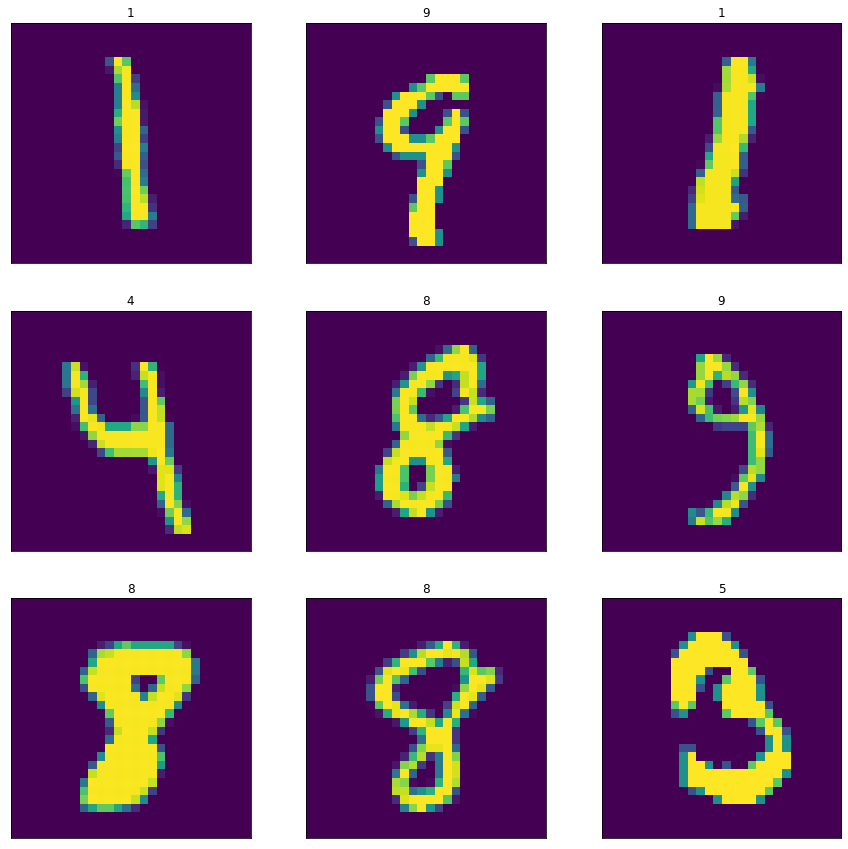

In [57]:
show_multiple_predictions(mlpModel1, test_dataset) 